In [57]:
%%time
import os
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from random import sample

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
import cv2

Wall time: 995 µs


In [58]:
### GET SUBFOLDERS DIRECTORIES
subfolders = [ f.path for f in os.scandir('../catchafish/data_test/') if f.is_dir()]

In [59]:
### GET ALL FILES
subfolding = [next(os.walk(f'{s}')) for s in subfolders]

In [60]:
def get_subfolding(subfolding):
    path, dirs, files = subfolding
    filenames = [ f'{path}/{f}' for f in files ]
    return filenames 

In [61]:
filenames_list = [get_subfolding(subfolding[i]) for i in range(len(subfolding))]
filenames = [ x for y in filenames_list for x in y ]

In [62]:
%%time
im_data = [cv2.imread(f'{f}') for f in filenames]

Wall time: 9.34 s


In [63]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

X_train_gray = rgb2gray(im_data)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
%%time
im_resized_data = [cv2.resize(im, (128, 128), interpolation=cv2.INTER_LINEAR) for im in im_data]

In [ ]:
%%time
gx = [cv2.Sobel(im,cv2.CV_64F,1,0,ksize=5) for im in im_resized_data]
gy = [cv2.Sobel(im,cv2.CV_64F,0,1,ksize=5) for im in im_resized_data]

In [ ]:
gx_array_scaled = np.array(gx)
gy_array_scaled = np.array(gy)

In [ ]:
gx_array_reshaped = np.reshape(gx_array_scaled,
                               (gx_array_scaled.shape[0],
                                gx_array_scaled.shape[1] * gx_array_scaled.shape[1] * gx_array_scaled.shape[3]))
gy_array_reshaped = np.reshape(gy_array_scaled,
                               (gy_array_scaled.shape[0],
                                gy_array_scaled.shape[1] * gy_array_scaled.shape[1] * gy_array_scaled.shape[3]))

In [ ]:
mmsacler_x, mmsacler_y = MinMaxScaler(), MinMaxScaler()

mmsacler_x.fit(gx_array_reshaped)
gx_array_rescaled = mmsacler_x.transform(gx_array_reshaped)

mmsacler_y.fit(gy_array_reshaped)
gy_array_rescaled = mmsacler_y.transform(gx_array_reshaped)

### What kinds of “features” are useful for classification tasks ?

#### EDGE DETECTION
#### STIF
#### HOG
#### SURF

### What is Histogram of Oriented Gradients ?

##### HOG ( histograms ) of directions of gradients ( oriented gradients ) are used as features. Gradients ( x and y derivatives ) of an image are useful because the magnitude of gradients is large around edges and corners ( regions of abrupt intensity changes ) and we know that edges and corners pack in a lot more information about object shape than flat regions.

### How to calculate Histogram of Oriented Gradients ?

#### To calculate a HOG descriptor, we need to first calculate the horizontal and vertical gradients
![image.png](attachment:image.png)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Text(0.5, 1.0, 'gradiant Y'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

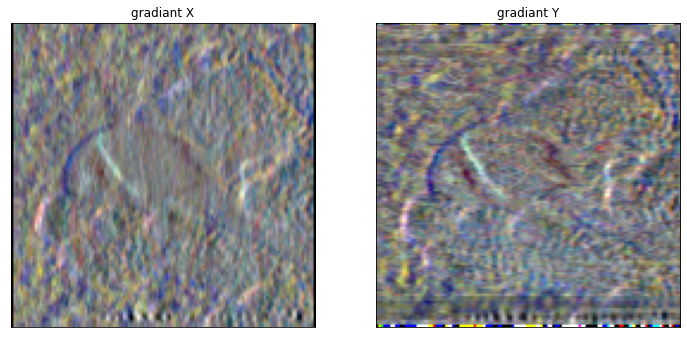

In [52]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1), plt.imshow(np.reshape(gx_array_rescaled[48],(128,128,3)), cmap = 'gray')
plt.title('gradiant X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(np.reshape(gy_array_rescaled[48],(128,128,3)), cmap = 'gray')
plt.title('gradiant Y'), plt.xticks([]), plt.yticks([])

In [38]:
im_resized_data_array = np.array(im_resized_data)

In [39]:
%%time
hogged_data = []
for im in im_resized_data_array:
    fd, hog_image = hog( resize(im, (128, 128)), 
                        orientations = 6 , 
                        pixels_per_cell=(3, 3), 
                        cells_per_block=(2, 2), 
                        visualize=True, 
                        multichannel=True)
    hogged_data.append(hog_image)

Wall time: 2min 26s


In [41]:
hogged_data_array = np.array(hogged_data)

In [42]:
X_hogged_reshaped = np.reshape(hogged_data_array, 
                               (hogged_data_array.shape[0], 
                                hogged_data_array.shape[1] * hogged_data_array.shape[1]))

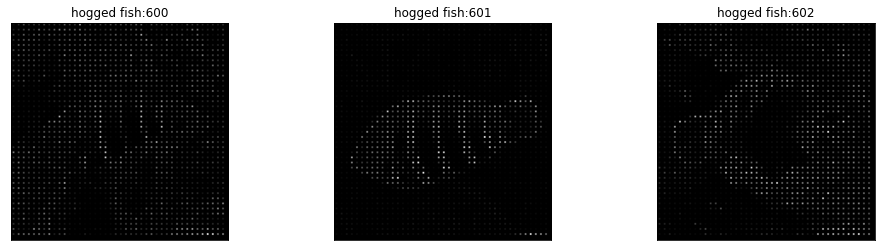

In [56]:
plt.figure(figsize=(28,4))
index = 600
for i, im in enumerate(hogged_data_array[index: index+3]):
    plt.subplot(1, 5, i+1)
    plt.title(f'hogged fish:{index+i}'), plt.xticks([]), plt.yticks([])
    plt.imshow(im,cmap=plt.cm.gray)